In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


In [49]:
customer_feedback = pd.read_csv("customer_feedback_cleaned.csv")
customer = pd.read_csv("customer_cleaned.csv")
expansion_outcome = pd.read_csv("expansion_outcome_cleaned.csv")
product = pd.read_csv("product_cleaned.csv")
utilization = pd.read_csv("utilization_cleaned.csv")

In [50]:
merged_data = (
    customer
    .merge(customer_feedback, on=["id", "score_date"], how="left")
    .merge(expansion_outcome, on=["id", "score_date"], how="left")
    .merge(product, on=["id", "score_date"], how="left")
    .merge(utilization, on=["id", "score_date"], how="left")
)

In [51]:
merged_data.to_csv("merged_data.csv", index=False)

In [52]:
df=pd.read_csv("merged_data.csv")

In [53]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13389 entries, 0 to 13388
Data columns (total 54 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   13389 non-null  object 
 1   score_date                           13389 non-null  object 
 2   segment_smb                          13389 non-null  int64  
 3   segment_non_smb                      13389 non-null  int64  
 4   segment_commercial                   13389 non-null  int64  
 5   segment_enterprise                   13389 non-null  int64  
 6   segment_midmarket                    13389 non-null  int64  
 7   region_emea                          13389 non-null  int64  
 8   region_apac                          13389 non-null  int64  
 9   region_latam                         13389 non-null  int64  
 10  region_amer                          13389 non-null  int64  
 11  customer_age_quarters       

In [54]:
print(df.head(10))

              id  score_date  segment_smb  segment_non_smb  \
0   JMAN_2429072  2023-02-10            1                0   
1   JMAN_9043466  2023-01-13            0                1   
2   JMAN_2452556  2023-02-24            0                1   
3   JMAN_2455113  2023-03-03            0                1   
4  JMAN_18127937  2023-02-10            0                1   
5   JMAN_2373631  2023-03-03            0                1   
6   JMAN_2447279  2023-03-03            1                0   
7   JMAN_9004478  2023-01-20            1                0   
8   JMAN_2477864  2023-03-24            1                0   
9   JMAN_2445629  2023-01-20            0                1   

   segment_commercial  segment_enterprise  segment_midmarket  region_emea  \
0                   0                   0                  0            1   
1                   1                   0                  0            1   
2                   0                   0                  0            1   
3        

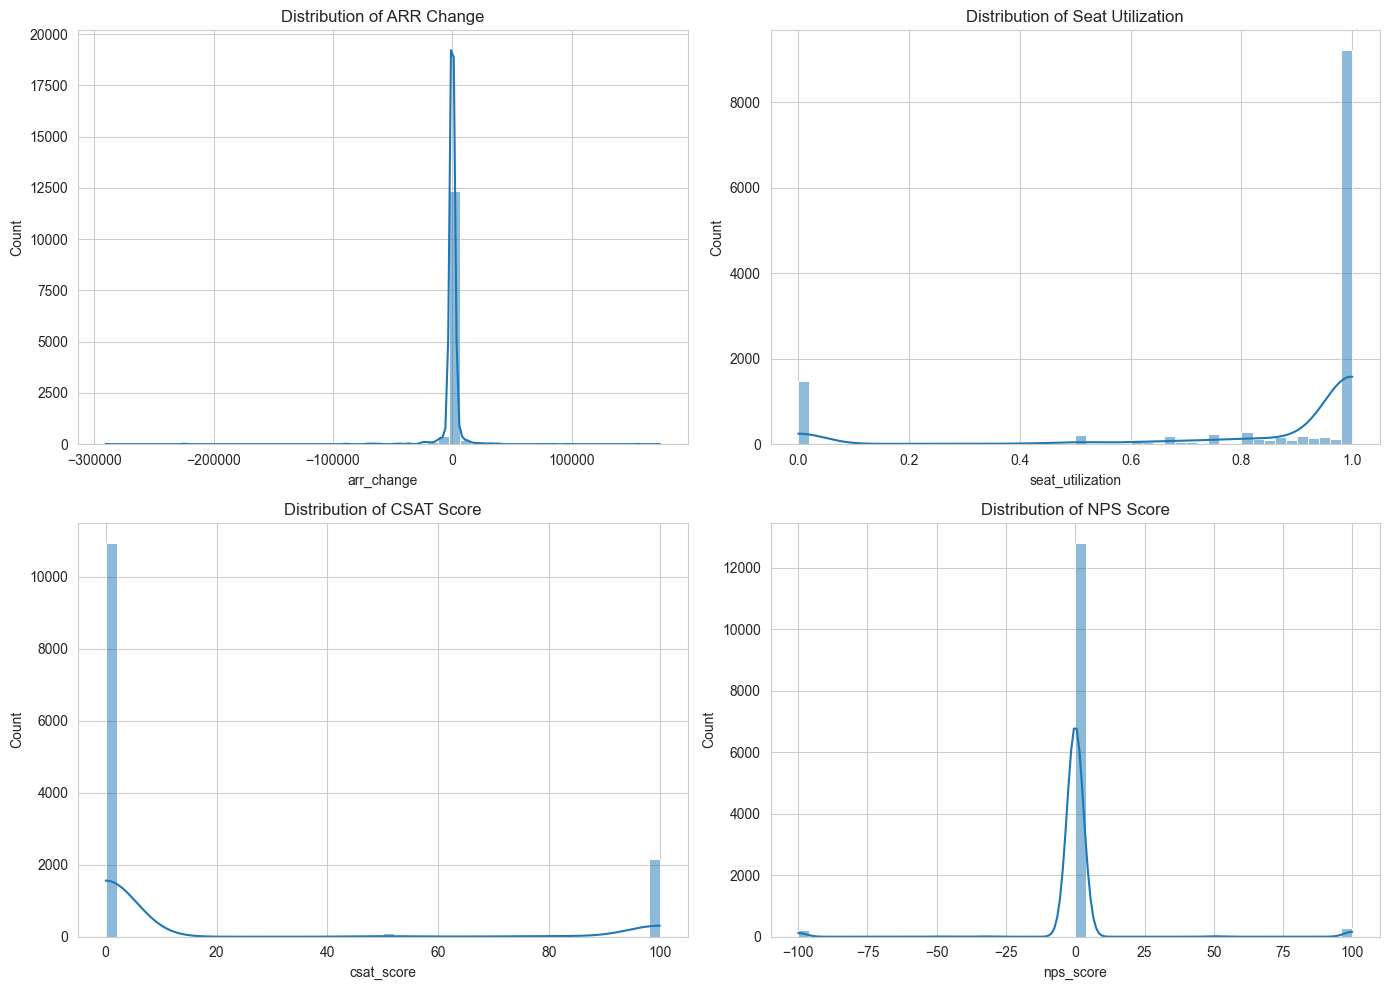

In [55]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df["arr_change"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of ARR Change")

sns.histplot(df["seat_utilization"], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Seat Utilization")

sns.histplot(df["csat_score"], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of CSAT Score")

sns.histplot(df["nps_score"], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribution of NPS Score")

plt.tight_layout()
plt.show()


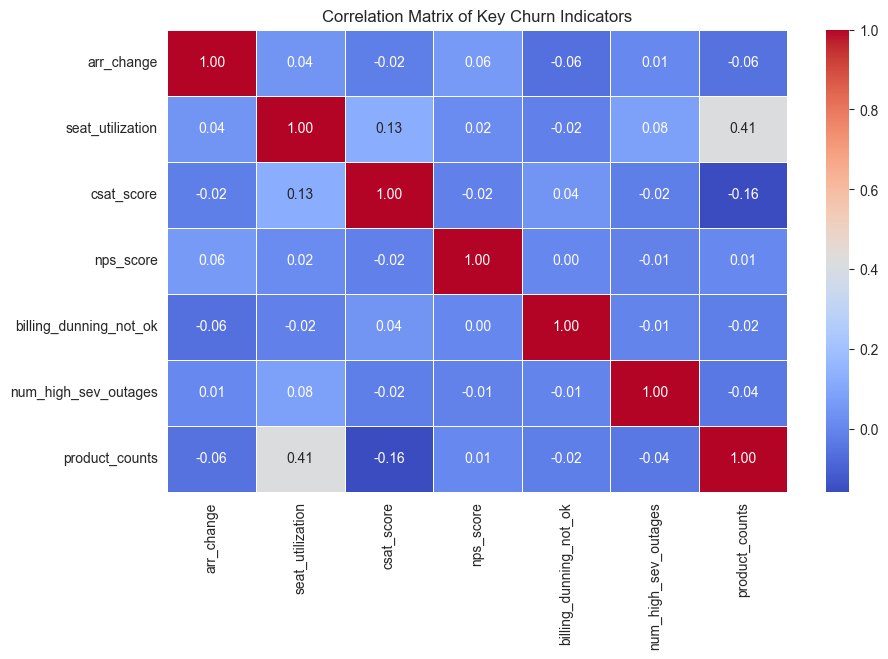

In [56]:
correlation_matrix = df[["arr_change", "seat_utilization", "csat_score", "nps_score",
                         "billing_dunning_not_ok", "num_high_sev_outages", "product_counts"]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Key Churn Indicators")
plt.show()


In [57]:
# df["churn"] = ((df["arr_change"] < -420) | (df["seat_utilization"] == 0)).astype(int)
# print("Churn Rate:", df["churn"].mean())
# print(df["churn"].value_counts())




df["seat_utilization_change"] = df["seat_utilization"] - df["seat_utilization_M_before"]
df["nps_change"] = df["nps_score"] - df["nps_score_all_time"]
df["csat_change"] = df["csat_score"] - df["csat_response_rate"]
df["arr_volatility"] = abs(df["current_arr"] - df["future_arr"]) / df["current_arr"]
df["discount_dependency"] = df["discount_arr_usd"] / df["current_arr"]
df["provisioning_complexity"] = df[["is_provisioned_any_channel_M_before"]].sum(axis=1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

df["churn"] = ((df["future_arr"] < 0.5 * df["current_arr"]) | 
               (df["seat_utilization"] < 0.5 * df["seat_utilization_M_before"])).astype(int)
print("Churn Rate:", df["churn"].mean())
print(df["churn"].value_counts())


Churn Rate: 0.05026514302785869
churn
0    12716
1      673
Name: count, dtype: int64


In [58]:
excluded_cols = ["id", "score_date", "crm_industry_current", "crm_employee_range", "churn"]
features = df.drop(columns=excluded_cols)
label_encoders = {}

In [59]:
for col in features.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col])
    label_encoders[col] = le

target = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [60]:
feature_importances = pd.Series(rf_model.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Top 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 arr_change                 0.281483
arr_volatility             0.196596
product_change_arr         0.142237
future_arr                 0.086093
seat_change_arr            0.058744
current_arr                0.032717
max_seats                  0.023284
provisioning_complexity    0.016292
max_seats_M_before         0.016083
seat_utilization_change    0.015786
dtype: float64


In [61]:
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9992531740104555
Precision: 1.0
Recall: 0.9827586206896551
Confusion Matrix:
 [[2562    0]
 [   2  114]]


C:\Users\SatheeshPeriyasamy\AppData\Local\Temp\ipykernel_10700\1393246777.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(10), y=feature_importances.index[:10], palette="viridis")


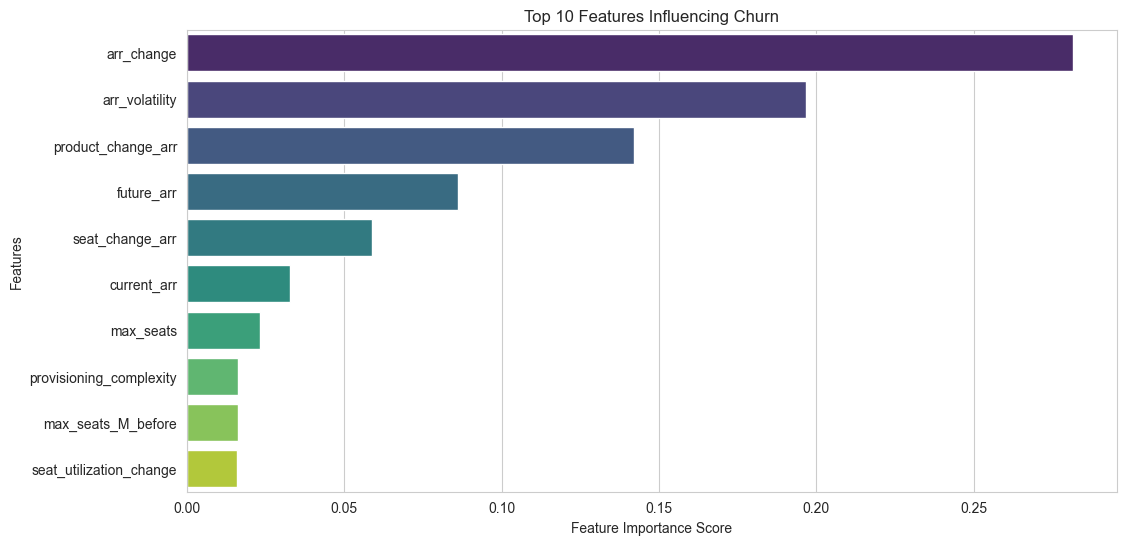

In [62]:
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.index[:10], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Features Influencing Churn")
plt.show()

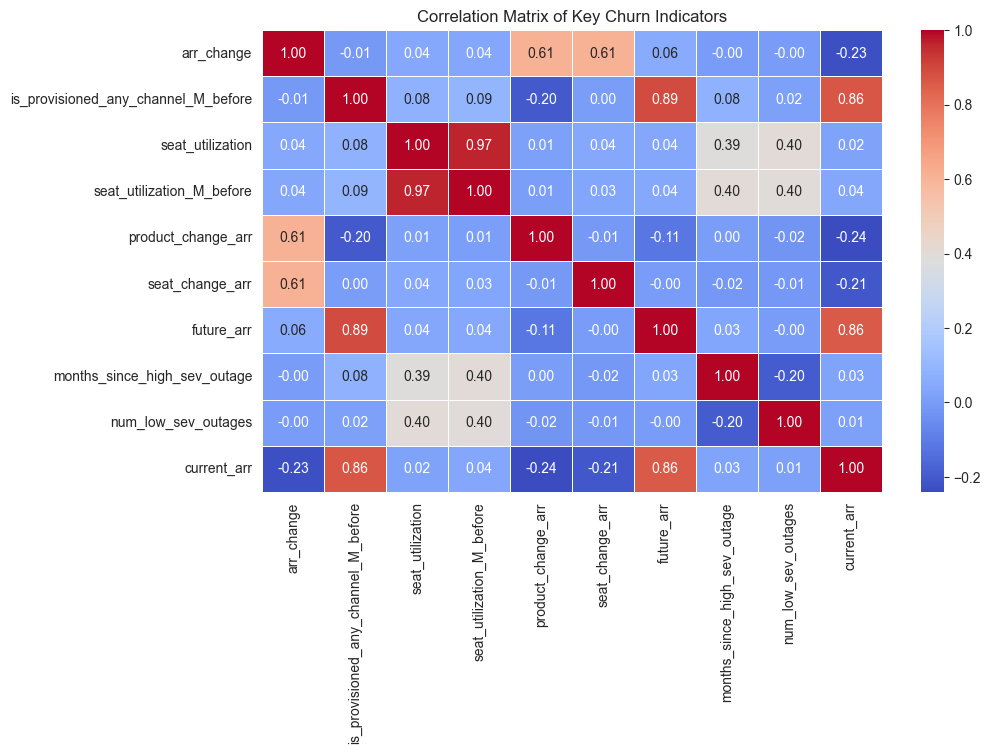

In [63]:
correlation_matrix = df[["arr_change", "is_provisioned_any_channel_M_before","seat_utilization","seat_utilization_M_before",
                   "product_change_arr","seat_change_arr","future_arr","months_since_high_sev_outage","num_low_sev_outages",
                       "current_arr"    ]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Key Churn Indicators")
plt.show()

In [64]:
df.to_csv("final_data.csv", index=False)

In [65]:
arr_result=df["arr_change"].value_counts()
arr_result.to_csv("arr_result.csv", index=False)

In [66]:
numeric_df = df.select_dtypes(include=["number"])
numeric_df.columns


Index(['segment_smb', 'segment_non_smb', 'segment_commercial',
       'segment_enterprise', 'segment_midmarket', 'region_emea', 'region_apac',
       'region_latam', 'region_amer', 'customer_age_quarters',
       'sales_assisted', 'legacy_flag', 'product_counts',
       'billing_dunning_not_ok', 'crm_success_owner_change', 'csat_score',
       'csat_response_rate', 'nps_score', 'nps_score_all_time',
       'avg_nps_rating', 'avg_nps_rating_all_time', 'outreach_call_90dayflag',
       'num_low_sev_outages', 'num_high_sev_outages',
       'months_since_high_sev_outage', 'num_tickets_deflected',
       'max_tickets_per_agent', 'current_arr', 'future_arr', 'arr_change',
       'fx_impact', 'seat_change_arr', 'product_change_arr',
       'discount_arr_usd', 'team_plus', 'pro_plus', 'ent_plus',
       'discount_arr_usd_percentage', 'product_counts_percentage',
       'total_pool_max_agents', 'max_seats', 'agent_utilization',
       'is_provisioned_any_channel_M_before', 'max_seats_M_before',

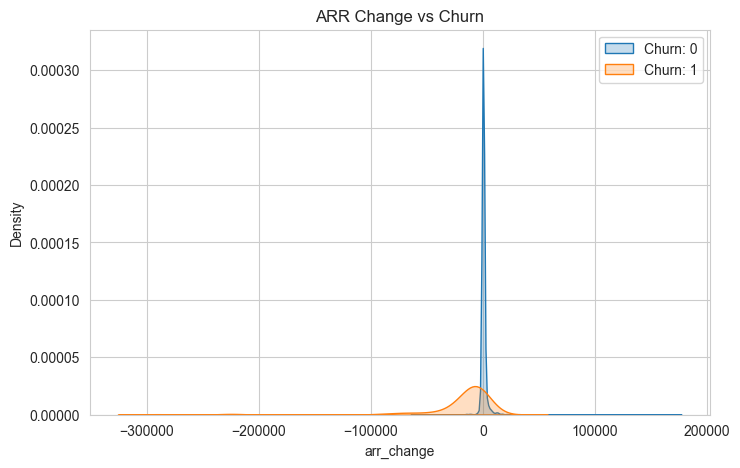

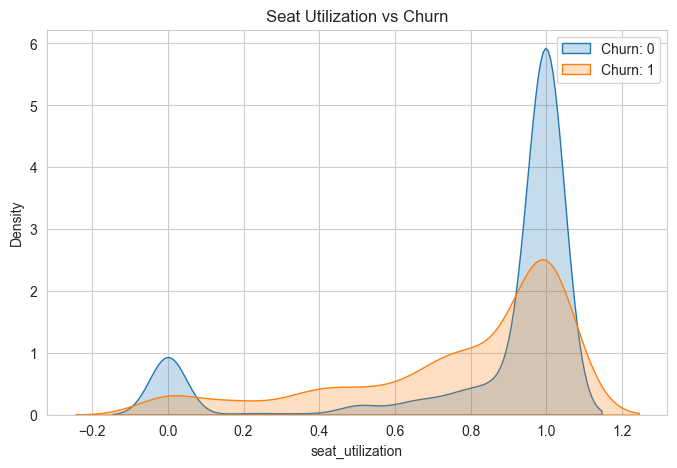

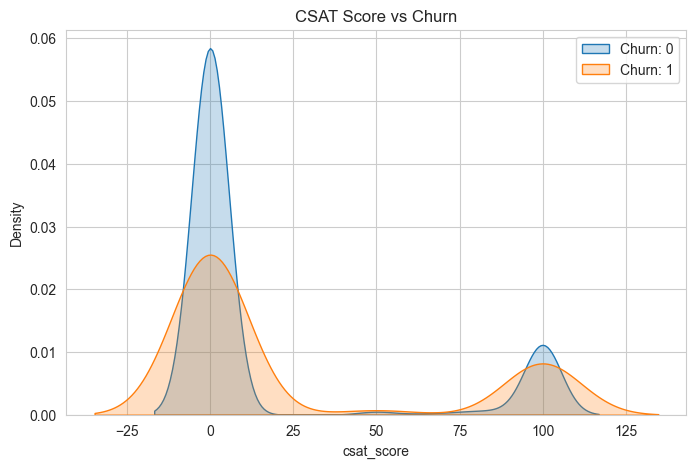

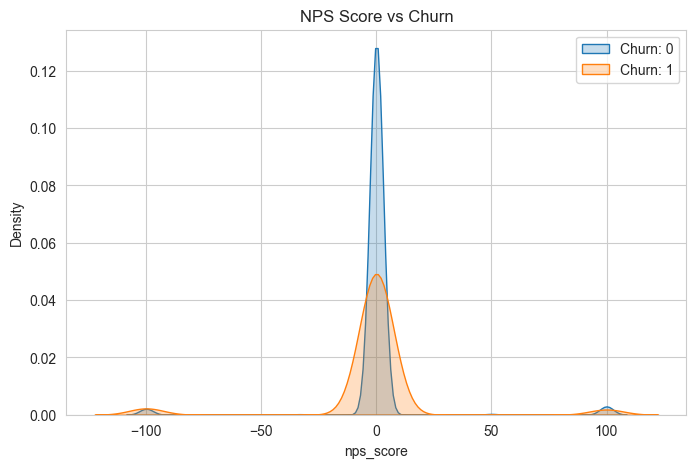

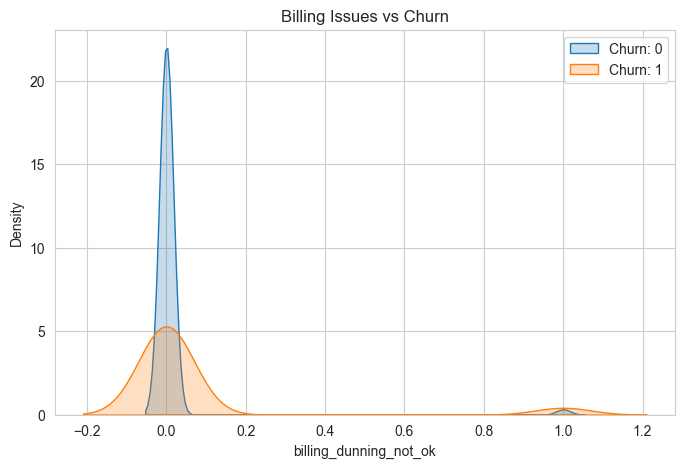

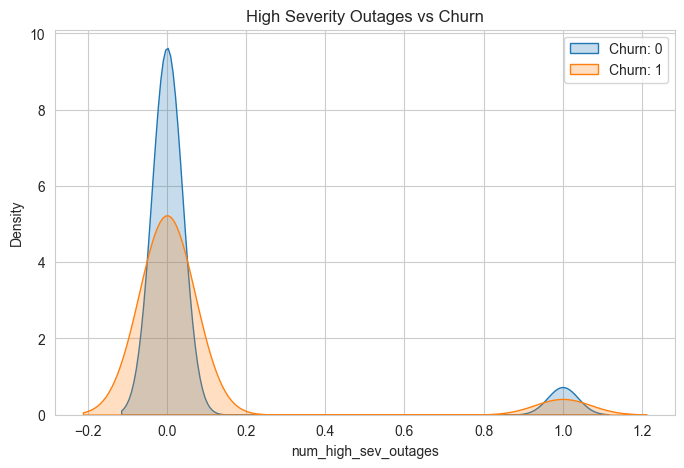

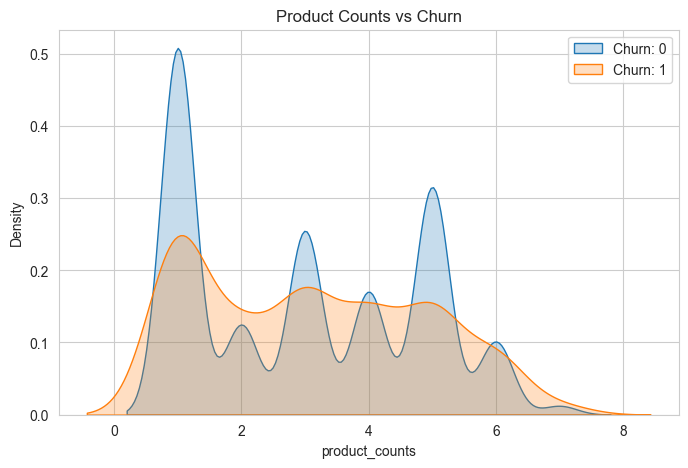

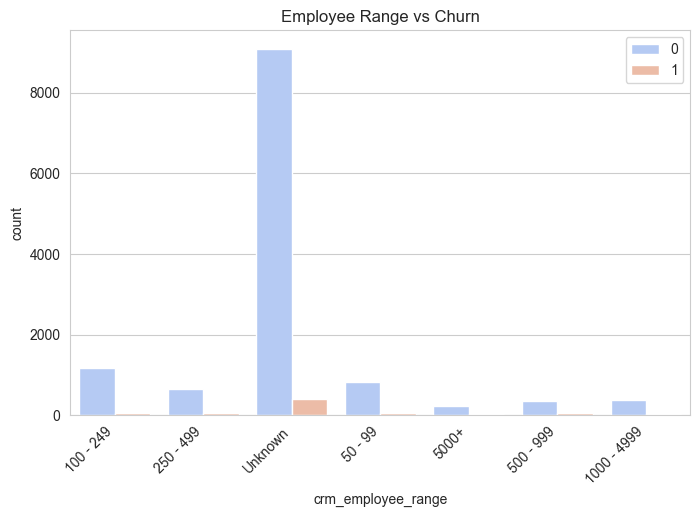

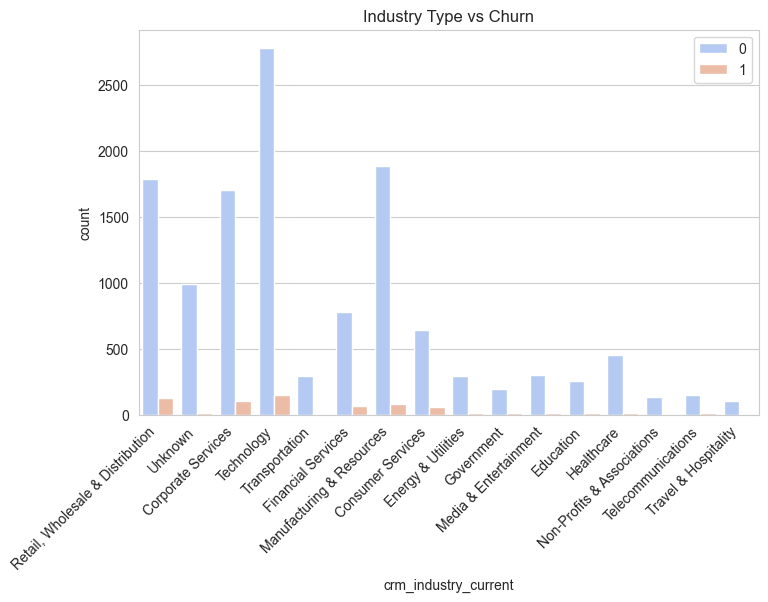

In [67]:
# hypotheses = [
#     ("arr_change", "ARR Change vs Churn"),
#     ("seat_utilization", "Seat Utilization vs Churn"),
#     ("csat_score", "CSAT Score vs Churn"),
#     ("nps_score", "NPS Score vs Churn"),
#     ("billing_dunning_not_ok", "Billing Issues vs Churn"),
#     ("num_high_sev_outages", "High Severity Outages vs Churn"),
#     ("product_counts", "Product Counts vs Churn"),
#     ("crm_employee_range", "Employee Range vs Churn"),
#     ("crm_industry_current", "Industry Type vs Churn")]

# for col, title in hypotheses:
#     plt.figure(figsize=(8, 5))
#     if df[col].dtype == "object":
#         sns.countplot(x=df[col], hue=df["churn"], palette="coolwarm")
#         plt.xticks(rotation=45, ha="right")
#     else:
#         sns.boxplot(x=df["churn"], y=df[col])
#     plt.title(title)
#     plt.show()






# hypotheses = [
#     ("arr_change", "ARR Change vs Churn"),
#     ("seat_utilization", "Seat Utilization vs Churn"),
#     ("csat_score", "CSAT Score vs Churn"),
#     ("nps_score", "NPS Score vs Churn"),
#     ("billing_dunning_not_ok", "Billing Issues vs Churn"),
#     ("num_high_sev_outages", "High Severity Outages vs Churn"),
#     ("product_counts", "Product Counts vs Churn"),
#     ("crm_employee_range", "Employee Range vs Churn"),
#     ("crm_industry_current", "Industry Type vs Churn")]

# for col, title in hypotheses:
#     plt.figure(figsize=(8, 5))
#     if df[col].dtype == "object":
#         sns.countplot(x=df[col], hue=df["churn"], palette="coolwarm")
#         plt.xticks(rotation=45, ha="right")
#     else:
#         sns.violinplot(x=df["churn"], y=df[col], palette="coolwarm")
#     plt.title(title)
#     plt.show()


hypotheses = [
    ("arr_change", "ARR Change vs Churn"),
    ("seat_utilization", "Seat Utilization vs Churn"),
    ("csat_score", "CSAT Score vs Churn"),
    ("nps_score", "NPS Score vs Churn"),
    ("billing_dunning_not_ok", "Billing Issues vs Churn"),
    ("num_high_sev_outages", "High Severity Outages vs Churn"),
    ("product_counts", "Product Counts vs Churn"),
    ("crm_employee_range", "Employee Range vs Churn"),
    ("crm_industry_current", "Industry Type vs Churn")]

for col, title in hypotheses:
    plt.figure(figsize=(8, 5))
    if df[col].dtype == "object":
        sns.countplot(x=df[col], hue=df["churn"], palette="coolwarm")
        plt.xticks(rotation=45, ha="right")
    else:
        for churn_value in df["churn"].unique():
            sns.kdeplot(data=df[df["churn"] == churn_value], x=col, label=f"Churn: {churn_value}", fill=True)
    plt.title(title)
    plt.legend()
    plt.show()

In [68]:
df.to_csv("final_data.csv", index=False)

NameError: name 'SMOTE' is not defined

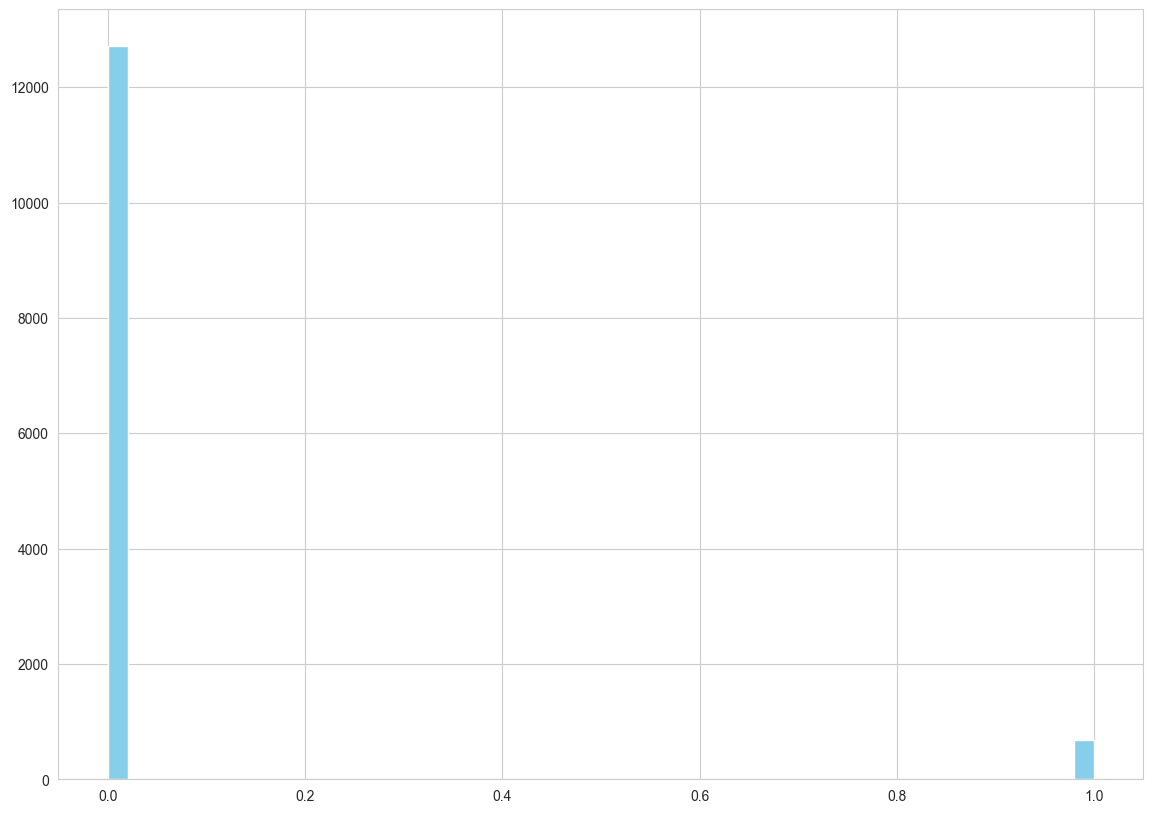

In [78]:
df["churn"].hist(figsize=(14, 10), bins=50, color="skyblue")
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)
y_resampled.hist(figsize=(14, 10), bins=50, color="skyblue")
plt.show()